# Neutron transport in H slab

Consider a slab of liqued Hydrogen.

Density: 0.07085 g/cm3
Only two reactions: capture and elastic scattering.

Source: 3 MeV neutrons placed at x=0

Goal: Estimate the flux vs x coordinate.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Microscopic XS

here comes text on microscopic xs. differential xs. etc

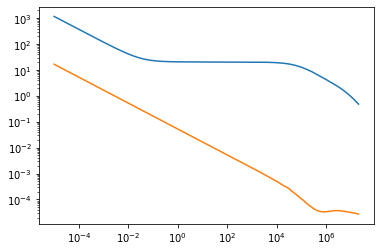

In [2]:
xsscatter=np.loadtxt('xs_Hscatter.dat',skiprows=2)
Es=xsscatter[:,0]
XSs=xsscatter[:,1]

xscapture=np.loadtxt('xs_Hcapture.dat',skiprows=2)
Ec=xscapture[:,0]
XSc=xscapture[:,1]

plt.figure()
plt.loglog(Es,XSs,label='scatter')
plt.loglog(Ec,XSc,label='capture')
plt.show()

## Macroscopic XS

text on macro xs, total, and mfp.

In [3]:
density = 0.07085 #g/cm3
A = 1
Numdens = density * 6.022E23 / A #let's ignore that it is H2 molecule

MXSc= XSc * Numdens*1e-24
MXSs= XSs * Numdens*1e-24

# Path to next collision

text on path and plotting the distribution for various energies.

In [4]:
def distanceToCollision(SigT):
    x=np.random.uniform(0,1)
    return -np.log(x)/SigT

# Reaction type

text on how $\Sigma_i/\Sigma_t$ relates to probability.

In [5]:
def reactionType(SigS,SigC,SigT): #TODO: more generic for any number of reactions.
    x=np.random.uniform(0,1)
    if x < SigS/SigT:
        return 'scatter'
    else:
        return 'capture'

# Scattering

text on scattering. Isotropic in CM, and limitations? Anisotropy in LAB. Kinematics of simple collision.

The following functions are just geometry, the real scattering part is done in the main.

In [6]:
def randomDir():
    mu=np.random.uniform(-1,1)
    theta=np.arccos(mu)
    phi=np.random.uniform(0,2*np.pi)

    u=np.sin(theta)*np.cos(phi)
    v=np.sin(theta)*np.sin(phi)
    w=np.cos(theta)
    return np.array([u,v,w])

def transformDir(u,v,w,mu): #TODO fix to receive array
    """
    transform coordinates according to openMC documentation.
    
    Parameters
    ----------
    u : float
        Old x-direction
    v : float
        Old y-direction
    w : float
        Old z-direction
    mu : float
        Lab cosine of scattering angle
    """
    phi=np.random.uniform(0,2*np.pi)
    un=mu*u+(np.sqrt(1-mu**2)*(u*w*np.cos(phi)-v*np.sin(phi)))/(np.sqrt(1-w**2))
    vn=mu*v+(np.sqrt(1-mu**2)*(v*w*np.cos(phi)+u*np.sin(phi)))/(np.sqrt(1-w**2))
    wn=mu*w-np.sqrt(1-mu**2)*np.sqrt(1-w**2)*np.cos(phi)
    return np.array([un,vn,wn])

def transformDirAliHag(u,v,w,mu): #TODO fix to receive array
    """
    transform coordinates from A. Haghighat
    
    Parameters
    ----------
    u : float
        Old x-direction
    v : float
        Old y-direction
    w : float
        Old z-direction
    mu : float
        Lab cosine of scattering angle
    """
    phi=np.random.uniform(0,2*np.pi)
    theta=np.arccos(mu)
    s=np.sqrt(1-w**2)

    un=-(u*w*np.cos(phi)/s-v/s)*np.sin(theta)+u*np.cos(theta)    

    vn=-(v*w*np.cos(phi)/s+u/s)*np.sin(theta)+v*np.cos(theta)

    wn=s*(np.sin(theta)*np.cos(phi))+w*np.cos(phi)

    return np.array([un,vn,wn])/np.linalg.norm(np.array([un,vn,wn]))

def transformDirLux(u,v,w,mu): #TODO fix to receive array
    """
    transform coordinates according to Lux&Koblinger
    
    Parameters
    ----------
    u : float
        Old x-direction
    v : float
        Old y-direction
    w : float
        Old z-direction
    mu : float
        Lab cosine of scattering angle
    """
    phi=np.random.uniform(0,2*np.pi)
    theta=np.arccos(mu)

    a=np.sqrt(1-w**2)
    wn=w*np.cos(theta) + a*np.cos(phi)
    b=np.cos(theta) - w*wn

    vn=(1/(1-w**2))*(b*v+a*u*np.sin(phi))
    #TODO Lux didnt give the coordinate for this
    #check reference
    un=(1/(1-w**2))*(b*u-a*v*np.sin(phi))

    return np.array([un,vn,wn])/np.linalg.norm(np.array([un,vn,wn]))

# Main

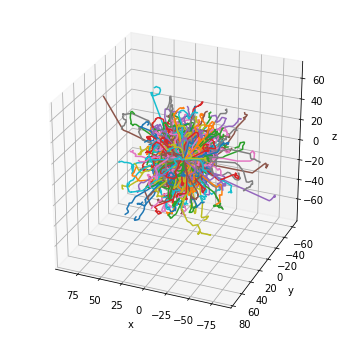

In [7]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
N=1000
D=100 #cm
E0=3e6 #eV
A=1
alpha=(A-1)**2/(A+1)**2

fig = plt.figure(figsize=plt.figaspect(1.0)*1.5) #Adjusts the aspect ratio and enlarges the figure (text does not enlarge)
ax = fig.gca(projection='3d')

muCs=[]
muLs=[]
for i in range(N):
    Xs=[]
    Ys=[]
    Zs=[]

    E=E0
    coord=np.array([0.0,0.0,0.0])
    direction=randomDir()
    while E>0.025: #TODO in case more nuclides will need an other step to sample nuclide
        SigS=np.interp(E,Es,MXSs) #TODO log interpol
        SigC=np.interp(E,Ec,MXSc) #TODO log interpol
        SigT=SigS+SigC
        dist=distanceToCollision(SigT)
        Xs.append(coord[0])
        Ys.append(coord[1])
        Zs.append(coord[2])
        coord=coord + dist*direction
        rtype=reactionType(SigS,SigC,SigT)
        if np.abs(coord[0])>D:  #leakage
            #print('leaked from')
            #print('x,y,z = %.2f \t %.2f \t %.2f'%(coord[0],coord[1],coord[2]))
            #print('E = %.2e eV'%E)
            break
        elif rtype=='capture':
            #print('captured at')
            #print('x,y,z = %.2f \t %.2f \t %.2f'%(coord[0],coord[1],coord[2]))
            #print('E = %.2e eV'%E)
            break
        else:
            #print('scattered')
            muC=np.random.uniform(-1,1)
            thetaC=np.arccos(muC)
            E=(((1+alpha)+(1-alpha)*muC)/2)*E
            thetaL=np.arctan2(np.sin(thetaC),((1/A)+muC))
            muL=np.cos(thetaL)
            muCs.append(muC)
            muLs.append(muL)
            direction=transformDir(direction[0],direction[1],direction[2],muL)

    ax.plot3D(Xs,Ys,Zs,label=str(i))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#plt.legend()
ax.azim = 113
ax.elev = 28
plt.show()

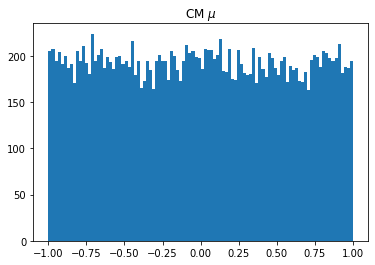

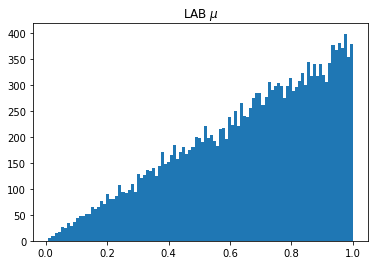

In [8]:
plt.figure()
plt.title(r'CM $\mu$')
plt.hist(muCs,100)
plt.show()
plt.figure()
plt.title(r'LAB $\mu$')
plt.hist(muLs,100)
plt.show()